# MCMC experiment: round 2

Mixture of Gaussians

In [1]:
using Gen
using PyPlot

## Define a model

In [2]:
@gen function gauss_mix(n_clusters::Int64, n_samples::Int64)
    
    cluster_means = [@trace(normal(0.0, 10.0), :means => i) for i=1:n_clusters]
    cluster_spreads = [@trace(gamma(1.0, 1.0), :spreads => i) for i=1:n_clusters]
    cluster_probs = fill(1.0/n_clusters, n_clusters)
    
    z = zeros(n_samples, 1)
    
    for j=1:n_samples
    
        c = @trace(categorical(cluster_probs), :cluster => j)
        z[j] = @trace(normal(cluster_means[c], cluster_spreads[c]), :z => j)
    end
    
    return z

end;

## Sanity check: simulate & visualize

In [3]:
n_samples = 1000
n_clusters = 4
    
tr = simulate(gauss_mix, (n_clusters, n_samples))
#zs = [tr[:z => i] for i=1:n_samples];

In [4]:
println(tr)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Int64, Int64], ##gauss_mix#371, Bool[0, 0], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}(), Dict{Any,Trie{Any,Gen.ChoiceOrCallRecord}}(:spreads => Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}(4 => Gen.ChoiceOrCallRecord{Float64}(0.10284754989308756, -0.10284754989308756, NaN, true),2 => Gen.ChoiceOrCallRecord{Float64}(2.5212262366121263, -2.5212262366121263, NaN, true),3 => Gen.ChoiceOrCallRecord{Float64}(5.282989110350114, -5.282989110350114, NaN, true),1 => Gen.ChoiceOrCallRecord{Float64}(0.6459164405862802, -0.6459164405862802, NaN, true)), Dict{Any,Trie{Any,Gen.ChoiceOrCallRecord}}()),:means => Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}(4 => Gen.ChoiceOrCallRecord{Float64}(5.669953395692956, -3.382265483745369, NaN, true),2 => Gen.ChoiceOrCallRecord{Float64}(4.580095497584581, -3.3264100000336914, 

.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),276 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),659 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),508 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),602 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),241 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),370 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),197 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),593 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),654 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),624 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),142 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),935 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),848 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),95

, NaN, true),603 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),27 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),134 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),215 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),131 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),391 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),249 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),882 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),207 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),173 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),542 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),499 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),201 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),477 => Gen.ChoiceOrCallRecord{Int64}(3, -1.386294361

),823 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),440 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),585 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),622 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),834 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),54 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),101 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),897 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),337 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),60 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),34 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),481 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),467 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),762 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN,

Int64}(2, -1.3862943611198906, NaN, true),590 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),390 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),619 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),484 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),169 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),129 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),88 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),429 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),937 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),149 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),439 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),783 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),529 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),63 => Gen.ChoiceOrCallR

NaN, true),798 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),181 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),894 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),768 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),356 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),458 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),194 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),52 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),233 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),234 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),367 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),758 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),278 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),959 => Gen.ChoiceOrCallRecord{Int64}(4, -1.38629436111

{Int64}(3, -1.3862943611198906, NaN, true),466 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),127 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),475 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),934 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),851 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),637 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),744 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),226 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),43 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),203 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),104 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),960 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),999 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true),468 => Gen.ChoiceOrCal

, NaN, true),812 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),632 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),618 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),341 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),186 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),321 => Gen.ChoiceOrCallRecord{Int64}(1, -1.3862943611198906, NaN, true),420 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),6 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),856 => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),322 => Gen.ChoiceOrCallRecord{Int64}(4, -1.3862943611198906, NaN, true),218 => Gen.ChoiceOrCallRecord{Int64}(2, -1.3862943611198906, NaN, true)), Dict{Any,Trie{Any,Gen.ChoiceOrCallRecord}}()),:z => Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}(306 => Gen.ChoiceOrCallRecord{Float64}(4.097771298643844, -3.362926994684991,

5.677701107961883, 1.352731496519381, NaN, true),831 => Gen.ChoiceOrCallRecord{Float64}(5.59938562536446, 1.120175219561054, NaN, true),736 => Gen.ChoiceOrCallRecord{Float64}(5.603979499410107, 1.149825334909226, NaN, true),183 => Gen.ChoiceOrCallRecord{Float64}(2.4297291962150536, -0.49841453889630066, NaN, true),522 => Gen.ChoiceOrCallRecord{Float64}(3.675572394184443, -2.0075156222471344, NaN, true),591 => Gen.ChoiceOrCallRecord{Float64}(5.497058224567636, -0.05744949551741518, NaN, true),860 => Gen.ChoiceOrCallRecord{Float64}(5.796595185536967, 0.5974520420384362, NaN, true),103 => Gen.ChoiceOrCallRecord{Float64}(5.401091899260107, -1.8967025939296804, NaN, true),931 => Gen.ChoiceOrCallRecord{Float64}(3.2755086075098143, -1.1174027865583054, NaN, true),345 => Gen.ChoiceOrCallRecord{Float64}(5.77259816380621, -2.6287822850880986, NaN, true),152 => Gen.ChoiceOrCallRecord{Float64}(5.913765782166665, -1.4543489746600093, NaN, true),742 => Gen.ChoiceOrCallRecord{Float64}(8.5026889159971

-3.7538173929113188, NaN, true),421 => Gen.ChoiceOrCallRecord{Float64}(5.624915918172315, 1.2596884673875164, NaN, true),451 => Gen.ChoiceOrCallRecord{Float64}(5.55235606135928, 0.7018710985840061, NaN, true),166 => Gen.ChoiceOrCallRecord{Float64}(5.569959899063849, 0.8829342399417103, NaN, true),397 => Gen.ChoiceOrCallRecord{Float64}(5.581382534741291, 0.9847483654239646, NaN, true),35 => Gen.ChoiceOrCallRecord{Float64}(2.9983054772854763, -0.725642248000399, NaN, true),816 => Gen.ChoiceOrCallRecord{Float64}(3.028314829101425, -0.7591631135771513, NaN, true),286 => Gen.ChoiceOrCallRecord{Float64}(5.764802821744155, 0.9303119055321287, NaN, true),145 => Gen.ChoiceOrCallRecord{Float64}(4.163717463095426, -1.8573210171059802, NaN, true),392 => Gen.ChoiceOrCallRecord{Float64}(20.89953933409575, -5.865762414521583, NaN, true),554 => Gen.ChoiceOrCallRecord{Float64}(23.678962416752658, -7.3521302242243465, NaN, true),346 => Gen.ChoiceOrCallRecord{Float64}(4.940807788316737, -2.68859534680397

, true),761 => Gen.ChoiceOrCallRecord{Float64}(14.617955427687377, -3.5261861716252643, NaN, true),251 => Gen.ChoiceOrCallRecord{Float64}(2.353638552748624, -0.5267927839811214, NaN, true),463 => Gen.ChoiceOrCallRecord{Float64}(4.9916372050878435, -1.8570060608325825, NaN, true),649 => Gen.ChoiceOrCallRecord{Float64}(1.8039173211906556, -1.1441038420056855, NaN, true),438 => Gen.ChoiceOrCallRecord{Float64}(10.030091633043696, -2.710800314486195, NaN, true),656 => Gen.ChoiceOrCallRecord{Float64}(0.897540767200133, -2.91039004306288, NaN, true),766 => Gen.ChoiceOrCallRecord{Float64}(5.6908435553935375, 1.334940548290474, NaN, true),757 => Gen.ChoiceOrCallRecord{Float64}(12.510578885432826, -3.0580030051684157, NaN, true),699 => Gen.ChoiceOrCallRecord{Float64}(0.43567180977141096, -3.443288873007875, NaN, true),55 => Gen.ChoiceOrCallRecord{Float64}(1.3831249057689985, -2.6476239436097155, NaN, true),909 => Gen.ChoiceOrCallRecord{Float64}(2.8991910878130978, -0.6302677855481484, NaN, true)

Float64}(5.764764690366111, 0.9306537605833838, NaN, true),16 => Gen.ChoiceOrCallRecord{Float64}(8.691742263455556, -2.6150278880888127, NaN, true),398 => Gen.ChoiceOrCallRecord{Float64}(1.0042624475172621, -3.3079411735136866, NaN, true),575 => Gen.ChoiceOrCallRecord{Float64}(5.567528975066101, 0.8596746294846254, NaN, true),913 => Gen.ChoiceOrCallRecord{Float64}(5.6940711147704794, 1.3280738986317886, NaN, true),875 => Gen.ChoiceOrCallRecord{Float64}(5.0588780339829285, -1.8617150492976076, NaN, true),805 => Gen.ChoiceOrCallRecord{Float64}(5.794166424667005, 0.6262518312769888, NaN, true),208 => Gen.ChoiceOrCallRecord{Float64}(5.805225641679532, 0.49060201737100617, NaN, true),896 => Gen.ChoiceOrCallRecord{Float64}(8.804311007386957, -2.6206113613093835, NaN, true),695 => Gen.ChoiceOrCallRecord{Float64}(2.144186678931705, -2.310416827421654, NaN, true),380 => Gen.ChoiceOrCallRecord{Float64}(2.7961499526851785, -0.5560787126674792, NaN, true),72 => Gen.ChoiceOrCallRecord{Float64}(5.67

, -2.8954793287078604, NaN, true),984 => Gen.ChoiceOrCallRecord{Float64}(11.424570030848372, -2.8788600827177024, NaN, true),221 => Gen.ChoiceOrCallRecord{Float64}(9.162967301811893, -2.6414286476068294, NaN, true),153 => Gen.ChoiceOrCallRecord{Float64}(1.743425618027287, -2.47662598829576, NaN, true),697 => Gen.ChoiceOrCallRecord{Float64}(2.688154383466536, -2.9750558941091065, NaN, true),579 => Gen.ChoiceOrCallRecord{Float64}(5.191503869318577, -1.8730881021322308, NaN, true),590 => Gen.ChoiceOrCallRecord{Float64}(8.232528860379647, -2.8930112157474994, NaN, true),390 => Gen.ChoiceOrCallRecord{Float64}(5.713897147480746, 1.2642887968501684, NaN, true),619 => Gen.ChoiceOrCallRecord{Float64}(3.585677768147061, -2.8391325843321744, NaN, true),484 => Gen.ChoiceOrCallRecord{Float64}(2.2113635995683376, -3.0590011687513177, NaN, true),169 => Gen.ChoiceOrCallRecord{Float64}(5.713935300056826, 1.264130226644613, NaN, true),129 => Gen.ChoiceOrCallRecord{Float64}(2.2600573900196133, -0.5807231

, NaN, true),40 => Gen.ChoiceOrCallRecord{Float64}(5.852470163845865, -0.21909412527895977, NaN, true),838 => Gen.ChoiceOrCallRecord{Float64}(11.128091233982055, -2.8372971960055606, NaN, true),599 => Gen.ChoiceOrCallRecord{Float64}(8.840086015463205, -3.271142886374394, NaN, true),417 => Gen.ChoiceOrCallRecord{Float64}(4.646184290130986, -1.84402747773852, NaN, true),891 => Gen.ChoiceOrCallRecord{Float64}(3.7040070793119626, -2.085382819319613, NaN, true),842 => Gen.ChoiceOrCallRecord{Float64}(4.406693026117525, -1.8460490586508171, NaN, true),884 => Gen.ChoiceOrCallRecord{Float64}(7.289572584053858, -2.421137838157591, NaN, true),12 => Gen.ChoiceOrCallRecord{Float64}(8.592186441694176, -2.6104681909039416, NaN, true),343 => Gen.ChoiceOrCallRecord{Float64}(6.792164897323369, -2.228580332060616, NaN, true),410 => Gen.ChoiceOrCallRecord{Float64}(10.654874224582906, -2.77748280602368, NaN, true),528 => Gen.ChoiceOrCallRecord{Float64}(-5.728916664901663, -5.654303886791414, NaN, true),626

Gen.ChoiceOrCallRecord{Float64}(5.557471586060579, 0.7575062844293249, NaN, true),328 => Gen.ChoiceOrCallRecord{Float64}(3.858235679637505, -1.884671481836291, NaN, true),748 => Gen.ChoiceOrCallRecord{Float64}(1.51176361369208, -2.5842282028899124, NaN, true),84 => Gen.ChoiceOrCallRecord{Float64}(5.69704901895926, -1.9418172562711173, NaN, true),738 => Gen.ChoiceOrCallRecord{Float64}(11.141324877280912, -2.8390852482207265, NaN, true),977 => Gen.ChoiceOrCallRecord{Float64}(6.223557236630112, -2.056138237194142, NaN, true),752 => Gen.ChoiceOrCallRecord{Float64}(2.208209736249894, -3.0595835649624386, NaN, true),645 => Gen.ChoiceOrCallRecord{Float64}(10.198860825864642, -2.7274341639188475, NaN, true),93 => Gen.ChoiceOrCallRecord{Float64}(2.761997789363675, -0.5371045770674827, NaN, true),425 => Gen.ChoiceOrCallRecord{Float64}(10.24002175975805, -2.7316457751275167, NaN, true),564 => Gen.ChoiceOrCallRecord{Float64}(5.63806348746905, 1.3074973448335743, NaN, true),608 => Gen.ChoiceOrCallR

{Float64}(2.6567253990395274, -0.4962079345113076, NaN, true),644 => Gen.ChoiceOrCallRecord{Float64}(11.915609734076128, -2.9546258326837584, NaN, true),906 => Gen.ChoiceOrCallRecord{Float64}(5.701888983961948, 1.3073595278215437, NaN, true),784 => Gen.ChoiceOrCallRecord{Float64}(5.79861052974445, 0.5731311040822825, NaN, true),636 => Gen.ChoiceOrCallRecord{Float64}(11.931651195644138, -2.95724669974696, NaN, true),211 => Gen.ChoiceOrCallRecord{Float64}(5.572704953383891, 0.9085278948651943, NaN, true),359 => Gen.ChoiceOrCallRecord{Float64}(13.904831404572635, -3.349943518111115, NaN, true),777 => Gen.ChoiceOrCallRecord{Float64}(6.314108144548557, -2.6031653462445528, NaN, true),332 => Gen.ChoiceOrCallRecord{Float64}(3.343209387686284, -1.2410656558684667, NaN, true),299 => Gen.ChoiceOrCallRecord{Float64}(8.08844456158244, -2.8118546792924493, NaN, true),363 => Gen.ChoiceOrCallRecord{Float64}(2.9644783362871245, -0.6904447832462428, NaN, true),198 => Gen.ChoiceOrCallRecord{Float64}(5.1

[3.5197896603826617; 1.6259509437131991; 4.451623046118351; 8.43265022946818; 5.69718606631739; 6.874129877377867; 5.7766600220932744; 6.51646204518459; 10.45760033296884; 4.541161277097966; 2.0621852432204144; 8.592186441694176; 2.6222246724071154; 2.8528902945675694; 5.508113658787584; 8.691742263455556; 1.7130747673868192; 5.644211065743679; 1.3965893374858942; -4.859123580940277; 4.28541719211543; 5.632239904830327; 4.342365157431246; 6.52674054937742; 5.680715812255928; 3.6833561770305034; 3.101745434468604; 2.595090531538897; 1.6413729288184644; 5.677107759221172; 3.467034371014183; 2.6270458224645625; 3.792162216703007; 5.6031400142951115; 2.9983054772854763; 5.502030369231905; 5.794616743575881; 5.64436001116955; 3.5824620950287667; 5.852470163845865; 2.0777411148885214; 0.28760641399602704; 5.778796172534246; 3.9909305430775066; 6.699345950283334; 3.210402440368211; 4.80384607520284; 13.776784216008673; 7.751800906958225; 19.640493302768213; -2.807687604895377; 5.7719433387436

; 2.7763429330040688; 2.1188825952980848; 2.844865855099812; 1.6397900199826791; 1.409203773693886; 12.053636590221096; 6.57971518418116; 1.837509213405525; 2.879838338034018; 2.7413059256963486; 12.047197911706743; 4.224933493369377; 3.2930084246295346; 2.12556224406011; 5.442004130667077; 5.747413868234774; 2.3245871038484074; 2.894394192033034; 6.227479416320819; 2.4954712119096136; 11.695897611657903; 23.678962416752658; 5.689968845077525; 16.944723682744304; 5.721833583003503; 0.16671427068205968; 4.45674638721489; 2.754327496146452; 5.585073633726345; 5.800324072333267; -0.6654416540930574; 5.63806348746905; 12.26822798526612; 4.6210316274419085; 3.046149404568286; 5.7499185598181555; 5.5957822782967845; 2.7617667754149946; 2.084321427336997; 5.611662796692753; 5.676022695375077; 3.5107324196765806; 5.567528975066101; 2.0755258581788967; 13.80107493916014; 15.085616153936368; 5.191503869318577; -0.37691633703373917; 2.84874398837673; 1.7279432975088609; 4.434529016293011; 5.49721

In [5]:
function plot_choices(zs, means, assignments)
    
    hist_colors = ["gray", "blue", "red", "orange", "yellow"]
    
    z_sets = []
    
    for (i, mean) in enumerate(means)
        plot([mean; mean], [0; n_samples], color="k")
        cluster_z = zs[assignments .== i]
        hist(cluster_z, 20, color=hist_colors[i])
    end
    
end;


function plot_trace(tr)
    
    zs = [tr[:z => j] for j=1:n_samples];
    means = [tr[:means => i] for i=1:n_clusters];
    assignments = [tr[:cluster => j] for j=1:n_samples]
    
    plot_choices(zs, means, assignments)

end;

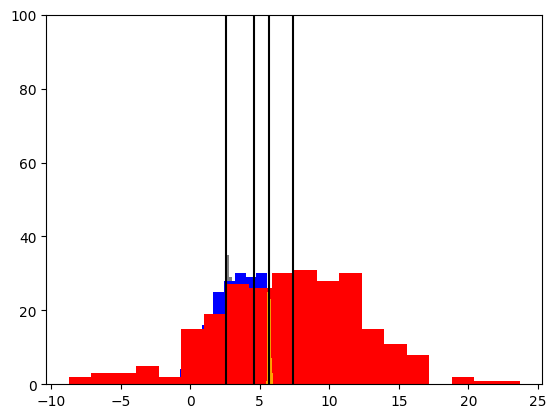

In [6]:
plot_trace(tr)
ylim(0, 100)
show()

## Inference: k-means-initialized MCMC

A straightforward importance sampling approach would have some issues: 
* Sampling (in)efficiency. Sampling the cluster centers from their prior will typically yield very improbable samples.
* (Un)Identifiability. Our model samples the cluster centers iid from a Gaussian. So the next sample will probably put the centers in a very different arrangement!

We can do better than this by:
* Initializing the cluster centers and assignments with a k-means heuristic
* using a custom proposal distribution for updating the cluster centers.
* keeping the cluster centers in sorted order. This eliminates ambiguity when the cluster centers are resampled.

Furthermore, we can improve the sampling speed by performing a customized, inexpensive Gibbs-sampling update for the cluster assignments.

In [ ]:
@gen function cluster_mean_proposal(tr, n_clusters)
    for i=1:n_clusters
        @trace(normal(tr[:means => i], 0.25), :means => i)
    end
end

@gen function cluster_spread_proposal(tr, n_clusters)
    for i=1:n_clusters
        @trace(gamma(1.0, 1.0), :spreads => i)
    end
end


function cluster_assignment_gibbs_update(tr, n_clusters, n_data)
    
    # The cluster assignments only ever interact with the 
    # cluster centers in sorted order.
    centers = [tr[:means => i] for i=1:n_clusters]
    srt_inds = sortperm(centers)
    centers = centers[srt_inds]
    spreads = [tr[:spreads => i] for i=1:n_clusters][srt_inds]
    
    new_assignments = Gen.choicemap()
    
    for j=1:n_data
        unnorm_probs = [ exp(-0.5* (tr[:z => j] - centers[i])^2 / (spreads[i]^2)) / spreads[i] for i=1:n_clusters]
        new_assignments[:cluster => j] = categorical(unnorm_probs ./ sum(unnorm_probs))
    end
    
    new_tr, _, _, _ = Gen.update(tr, (n_clusters, n_data), (), new_assignments)
    return new_tr
    
end


In [ ]:
using Statistics

function mean_update(data, cluster_assignments, k)
    return [mean(data[cluster_assignments .== i]) for i=1:k]
end

function cluster_update(data, means)
    
    dists = map(abs, data .- transpose(means))
    min_inds = argmin(dists, dims=2)
    
    return [min_inds[i][2] for i=1:length(min_inds)]
end


function kmeans(data::Array{Float64,1}, k::Int64, max_iter::Int64=1000)
    
    # random initialization
    cluster_assignments = zeros(size(data)[1])
    means = rand(data, k)
    
    i = 1
    while i <= max_iter
        
        cluster_assignments = cluster_update(data, means)
        new_means = mean_update(data, cluster_assignments, k)
        
        if new_means == means
            break
        end
        
        means = new_means
        i += 1
        
    end
    
    # Sort the means in order to ameliorate
    # identifiability issues.
    srt_inds = sortperm(means)
    inv_map = zeros(size(srt_inds))
    for (i, ind) in enumerate(srt_inds)importance sampling
        inv_map[ind] = i
    end
    ca = map(x->inv_map[x], cluster_assignments)
    
    return means[srt_inds], ca
end

In [ ]:
function smarter_mcmc_sample(tr, n_clusters, n_data)
    
    tr, _ = Gen.mh(tr, cluster_mean_proposal, (n_clusters,))
    tr, _ = Gen.mh(tr, cluster_spread_proposal, (n_clusters,))
    tr = cluster_assignment_gibbs_update(tr, n_clusters, n_data)
    
    return tr
end

In [ ]:
function smarter_mcmc_inference(tr, n_samples, n_clusters, n_data, burnin=10, thinning=10)
    
    means = zeros(n_samples, n_clusters)
    spreads = zeros(n_samples, n_clusters)
    assignments = zeros(n_data, n_clusters)
    
    for b=1:burnin
        tr = smarter_mcmc_sample(tr, n_clusters, n_data)
    end
    println("finished burnin; now sampling...")
    for s=1:n_samples
        for t=1:thinning
            tr = smarter_mcmc_sample(tr, n_clusters, n_data)
        end
        
        for i=1:n_clusters
            means[s,i] = tr[:means => i]
            spreads[s,i] = tr[:spreads => i]
        end
        for j=1:n_data
            assignments[j,tr[:cluster => j]] += 1
        end
    end
    
    println("postprocessing...")
    for s=1:n_samples
        srt_inds = sortperm(means[s,:])
        means[s,:] = means[s,srt_inds]
        spreads[s,:] = spreads[s,srt_inds]
    end
        
    return means, spreads, assignments
end

In [ ]:
function initialize_trace_kmeans(dataset, n_clusters, max_iters=1000)
    
    init_settings = Gen.choicemap()
    means, assignments = kmeans(dataset, n_clusters, max_iters)
    for i=1:n_clusters
        init_settings[:means => i] = means[i]
    end
    for j=1:length(dataset)
        init_settings[:cluster => j] = assignments[j]
        init_settings[:z => j] = dataset[j]
    end
       
    tr, _ = Gen.generate(gauss_mix, (n_clusters, length(dataset)), init_settings)
    
    return tr
end

In [ ]:
tr = initialize_trace_kmeans(zs, 4)
plot_trace(tr)
ylim(0,30)
show()

In [ ]:
means, spreads, assignments = smarter_mcmc_inference(tr, 1000, 4, length(zs), 100, 10)

In [ ]:
hist(means[:,4])
show()

## Inference: k-means-guided MCMC

